# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [157]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [158]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from datetime import datetime
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [159]:
warnings.filterwarnings("ignore", category=FutureWarning)
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    hidden_layers = ast.literal_eval(f"({input('Hidden Layers: eg. "100, 100"')})")
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [160]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['AA', 'AAT', 'ABR', ..., 'BABA', 'WB', 'SYDB.CO'], dtype=object)

#### Download annual financial data

In [161]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            if len(earning_dates) == 5:
                earning_dates.remove(earning_dates[4])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f"{symbol} had {len(earning_dates)} earning dates, not 5")
                continue
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Name': ticker.info["displayName"], 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 4:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because the length of the df was not 4, it was {len(ticker_df)}')
                continue

            if ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
                    print(error)
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [162]:
if debugging:
    display(df)

### Impution and encoding

In [163]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Name', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [164]:
pred_data = pd.DataFrame()
train_data = pd.DataFrame()
for i in range(int(len(df) / 4)):
    pred_data = pd.concat([pred_data, df.iloc[[i*4]]]) 
    train_data = pd.concat([train_data, df.iloc[[1+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*4]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*4]]])
if debugging:
    print('Prediction Data:')
    display(pred_data)
    print('Train and Test Data:')
    display(train_data)

### Labeling

In [165]:
ignore_columns = ["Ticker", "Name", "Date", '3M Future Change', '6M Future Change', '1Y Future Change']
X_pred = pred_data.drop(ignore_columns, axis=1)
X_train = train_data.drop(ignore_columns, axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

if debugging:
    display(X_train)
    display(y_train)
    display(X_test)
    display(y_test)

## Model Training

In [166]:
if train_new_model:
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        learning_rate="adaptive",
        early_stopping=True,
        verbose=True,
        n_iter_no_change=20
    )
    model.fit(X_train, y_train)

Iteration 1, loss = 104.53938987
Validation score: -1.146779
Iteration 2, loss = 0.79137882
Validation score: -0.552579
Iteration 3, loss = 0.33396044
Validation score: -0.213682
Iteration 4, loss = 0.28271582
Validation score: -0.891265
Iteration 5, loss = 0.14702004
Validation score: -0.275459
Iteration 6, loss = 0.12180144
Validation score: -0.302348
Iteration 7, loss = 0.15310107
Validation score: -0.509928
Iteration 8, loss = 0.23532084
Validation score: -0.231674
Iteration 9, loss = 0.39259045
Validation score: -0.208290
Iteration 10, loss = 0.20626737
Validation score: -0.041702
Iteration 11, loss = 0.11783288
Validation score: -0.039946
Iteration 12, loss = 0.09302641
Validation score: -0.031343
Iteration 13, loss = 0.08870937
Validation score: -0.036445
Iteration 14, loss = 0.08794294
Validation score: -0.029019
Iteration 15, loss = 0.08748580
Validation score: -0.035763
Iteration 16, loss = 0.08882051
Validation score: -0.036128
Iteration 17, loss = 0.08785379
Validation scor

## Testing and benchmarking

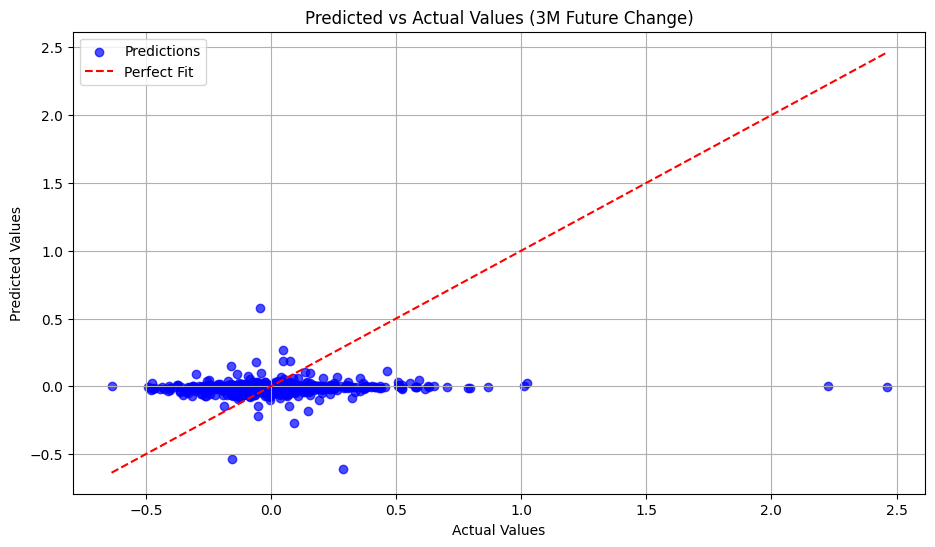

3M Future Change - R²: -0.0304
3M Future Change - MSE: 0.0607
3M Future Change - MAE: 0.1606


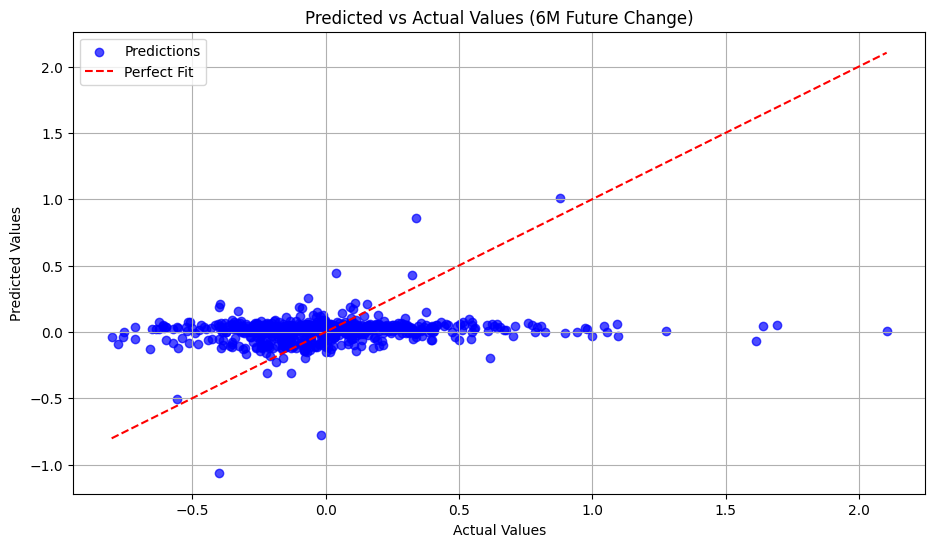

6M Future Change - R²: 0.0064
6M Future Change - MSE: 0.1066
6M Future Change - MAE: 0.2325


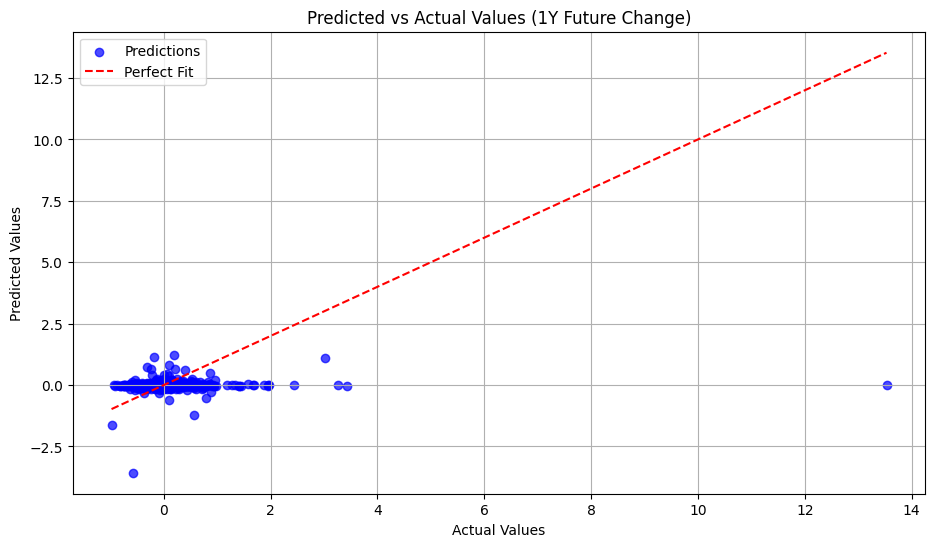

1Y Future Change - R²: -0.0497
1Y Future Change - MSE: 0.4968
1Y Future Change - MAE: 0.3397

Overall Scores:
Mean - R²: -0.0245
Mean - MSE: 0.2213
Mean - MAE: 0.2442


In [167]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [168]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [169]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0081677773957234


In [170]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

,Ticker,Name,mean (%),3m (%),6m (%),1y (%)
0,AA,Alcoa,-3.409956,-5.374477,-8.130804,3.275411
1,AAT,American Assets Trust,6.763109,5.485524,6.733401,8.070403
2,ABR,Arbor Realty Trust,6.897894,5.505712,7.008386,8.179585
3,ACI,Albertsons Companies,5.869118,5.216651,4.771614,7.619088
4,ACRE,Ares Commercial Real Estate,6.900266,5.507250,7.010586,8.182963
...,...,...,...,...,...,...
1565,PDD,PDD,6.360725,5.244794,5.874369,7.963012
1566,BIDU,Baidu,6.342935,5.444908,5.811676,7.772220
1567,NTES,NetEase,5.918443,4.782889,4.805859,8.166583
1568,IQ,iQIYI,6.168962,5.951924,5.015802,7.539160


In [171]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [172]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'MATAS.CO'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://afd1926eaa48b92484.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
